# Example of the algorithm implementation

This Jupyter notebook contains an implementation and explanation of the algorithm developed for the detection of seismic events in other celestial bodies during the NASA International Space Apps Challenge.

In [1]:
import numpy as np
import pandas as pd
from obspy import read
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from matplotlib import cm
import os
import scipy 
from algorithm import FourierTransformation, FourierFiltering, FourierInverseTransform, PowerSpectralDensityMax

# 1. Load the data

Here we load one observation of all the data provided by NASA to exemplify the use of our algorithm. The functions provided  in algorithm.py don't take the data as an argument, instead path to the data is given, but for illustrating purposes, the data will be loaded and plotted in this notebook.

In [2]:
cat_directory = './data/lunar/training/catalogs/'
cat_file = cat_directory + 'apollo12_catalog_GradeA_final.csv'
cat = pd.read_csv(cat_file)
cat

,filename,time_abs(%Y-%m-%dT%H:%M:%S.%f),time_rel(sec),evid,mq_type
0,xa.s12.00.mhz.1970-01-19HR00_evid00002,1970-01-19T20:25:00.000000,73500.0,evid00002,impact_mq
1,xa.s12.00.mhz.1970-03-25HR00_evid00003,1970-03-25T03:32:00.000000,12720.0,evid00003,impact_mq
2,xa.s12.00.mhz.1970-03-26HR00_evid00004,1970-03-26T20:17:00.000000,73020.0,evid00004,impact_mq
3,xa.s12.00.mhz.1970-04-25HR00_evid00006,1970-04-25T01:14:00.000000,4440.0,evid00006,impact_mq
4,xa.s12.00.mhz.1970-04-26HR00_evid00007,1970-04-26T14:29:00.000000,52140.0,evid00007,deep_mq
...,...,...,...,...,...
71,xa.s12.00.mhz.1974-10-14HR00_evid00156,1974-10-14T17:43:00.000000,63780.0,evid00156,impact_mq
72,xa.s12.00.mhz.1975-04-12HR00_evid00191,1975-04-12T18:15:00.000000,65700.0,evid00191,impact_mq
73,xa.s12.00.mhz.1975-05-04HR00_evid00192,1975-05-04T10:05:00.000000,36300.0,evid00192,impact_mq
74,xa.s12.00.mhz.1975-06-24HR00_evid00196,1975-06-24T16:03:00.000000,57780.0,evid00196,impact_mq


In [3]:
row = cat.iloc[6]

arrival_time = datetime.strptime(row['time_abs(%Y-%m-%dT%H:%M:%S.%f)'],'%Y-%m-%dT%H:%M:%S.%f')
arrival_time

datetime.datetime(1970, 6, 26, 20, 1)

In [4]:
# If we want the value of relative time, we don't need to use datetime
arrival_time_rel = row['time_rel(sec)']
arrival_time_rel

np.float64(72060.0)

In [5]:
# Let's also get the name of the file
test_filename = row.filename
test_filename

'xa.s12.00.mhz.1970-06-26HR00_evid00009'

In [6]:
data_directory = './data/lunar/training/data/S12_GradeA/'
csv_file = f'{data_directory}{test_filename}.csv'
data_cat = pd.read_csv(csv_file)
data_cat

,time_abs(%Y-%m-%dT%H:%M:%S.%f),time_rel(sec),velocity(m/s)
0,1970-06-26T00:00:00.116000,0.000000,-6.727977e-16
1,1970-06-26T00:00:00.266943,0.150943,-8.646711e-16
2,1970-06-26T00:00:00.417887,0.301887,-9.298738e-16
3,1970-06-26T00:00:00.568830,0.452830,-8.589095e-16
4,1970-06-26T00:00:00.719774,0.603774,-7.139047e-16
...,...,...,...
572418,1970-06-27T00:00:02.832981,86402.716981,5.039820e-17
572419,1970-06-27T00:00:02.983925,86402.867925,-9.191068e-18
572420,1970-06-27T00:00:03.134868,86403.018868,-2.796955e-17
572421,1970-06-27T00:00:03.285811,86403.169811,-9.037156e-17


The loaded data contains a time measurement of the event and the velocity in m/s detected by the sensors. In the following cell we plot the time (relative to the start of the measurement) against the velocity captured by the sensor.

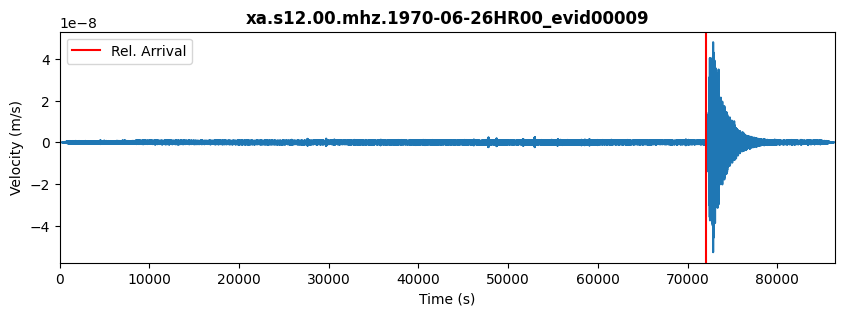

In [7]:
# Read in time steps and velocities
csv_times = np.array(data_cat['time_rel(sec)'].tolist())
csv_data = np.array(data_cat['velocity(m/s)'].tolist())

# Plot the trace! 
fig,ax = plt.subplots(1,1,figsize=(10,3))
ax.plot(csv_times,csv_data)

# Make the plot pretty
ax.set_xlim([min(csv_times),max(csv_times)])
ax.set_ylabel('Velocity (m/s)')
ax.set_xlabel('Time (s)')
ax.set_title(f'{test_filename}', fontweight='bold')

# Plot where the arrival time is
arrival_line = ax.axvline(x=arrival_time_rel, c='red', label='Rel. Arrival')
ax.legend(handles=[arrival_line])

# 2. Calculate Fourier Transform

First, the Fourier Transform of the velocity is calculated using the FourierTransformation function.

In [8]:
fft_values, frequencies = FourierTransformation(file_path = csv_file, sampling_rate = 6.625)

In [9]:
amplitude = np.abs(fft_values)

The amplitude of the Fourier Transformation values are plotted. Both all the amplitudes and only the possitive half (due to the amplitude of the Fourier values being symmetric) are represented.

Text(0.5, 1.0, 'Amplitude vs Frequency Plot')

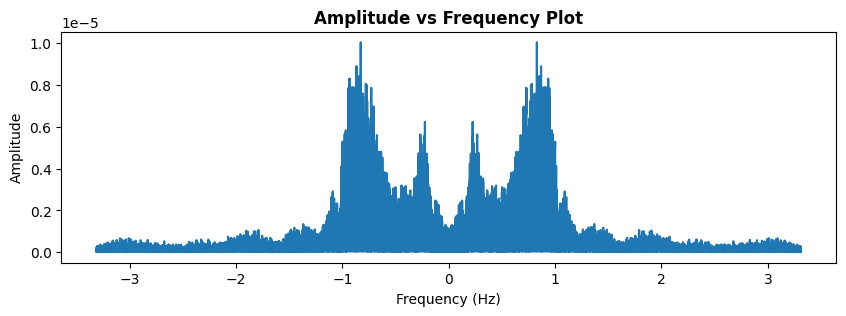

In [10]:
fig,ax = plt.subplots(1,1,figsize=(10,3))

ax.plot(frequencies, amplitude)
ax.set_ylabel('Amplitude')
ax.set_xlabel('Frequency (Hz)')
ax.set_title("Amplitude vs Frequency Plot", fontweight='bold')

Text(0.5, 1.0, 'Amplitude vs Frequency Plot')

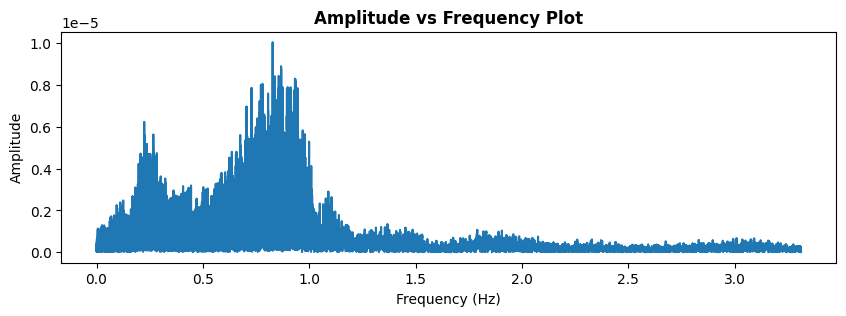

In [11]:
fig,ax = plt.subplots(1,1,figsize=(10,3))
ax.plot(frequencies[:len(frequencies)//2], amplitude[:len(amplitude)//2])
ax.set_ylabel('Amplitude')
ax.set_xlabel('Frequency (Hz)')
ax.set_title("Amplitude vs Frequency Plot", fontweight='bold')

# 3. Filtering of the Fourier Transform data

A filter to the Fourier Transform values is applied, keeping only the values around the N values with a higher amplitude. The rest of values are fixed to 0.

In [12]:
filtered_fft = FourierFiltering(fft_values = fft_values, frequencies = frequencies, N = 10, window_size = 50)

The filtered amplitudes are plotted against the frequency.

Text(0.5, 1.0, 'Amplitude vs Frequency Plot')

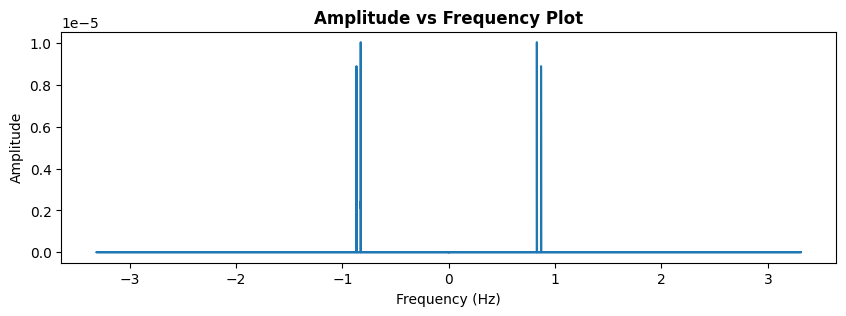

In [13]:
fig,ax = plt.subplots(1,1,figsize=(10,3))

ax.plot(frequencies, np.abs(filtered_fft))
ax.set_ylabel('Amplitude')
ax.set_xlabel('Frequency (Hz)')
ax.set_title("Amplitude vs Frequency Plot", fontweight='bold')

# 4. Revert the transformation

The filtered Fourier Transform values are transformed back to the initial space of time vs. velocity using the inverse of the Fourier Transform.

In [14]:
velocity_transformed = FourierInverseTransform(filtered_fft = filtered_fft)

A plot of the filtered data in the original space can be seen in the following figure:

/opt/conda/lib/python3.11/site-packages/matplotlib/cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/opt/conda/lib/python3.11/site-packages/matplotlib/cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


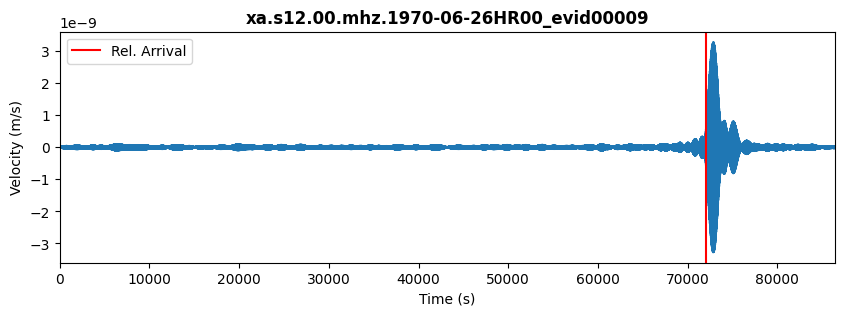

In [15]:
csv_times = np.array(data_cat['time_rel(sec)'].tolist())
csv_data = np.array(data_cat['velocity(m/s)'].tolist())

fig,ax = plt.subplots(1,1,figsize=(10,3))
ax.plot(csv_times,velocity_transformed.tolist())

ax.set_xlim([min(csv_times),max(csv_times)])
ax.set_ylabel('Velocity (m/s)')
ax.set_xlabel('Time (s)')
ax.set_title(f'{test_filename}', fontweight='bold')

arrival_line = ax.axvline(x=arrival_time_rel, c='red', label='Rel. Arrival')
ax.legend(handles=[arrival_line])

# 5. Obtention of the start of the seismic event.

The start of the seismic event is calculated by calculating the Power Spectral Density (PSD) of the filtered data in the original space and calculating the point where this power is highest. This is done using the PowerSpectralDensityMax function, which also returns an indicator that checks if that maximum is a seismic event by comparing its power to the average of the powers of the points close in time to this maximum

In [16]:
start_time, seismic_indicator = PowerSpectralDensityMax(file_path = csv_file,
                                                            velocity_transformed = velocity_transformed,
                                                            sampling_rate = 6.625,
                                                            threshold = 10000,
                                                            peak_difference = 1.4)

/home/jovyan/work/Resources/algorithm.py:110: UserWarning: Input data is complex, switching to return_onesided=False
  f, t, sxx = scipy.signal.spectrogram(velocity_transformed, sampling_rate)


The spectrogram of the filtered data is also calculated here for representation purposes.

In [17]:
sampling_rate = 6.625

In [18]:
f, t, sxx = scipy.signal.spectrogram(velocity_transformed, sampling_rate)

/tmp/ipykernel_136234/3825568330.py:1: UserWarning: Input data is complex, switching to return_onesided=False
  f, t, sxx = scipy.signal.spectrogram(velocity_transformed, sampling_rate)


/tmp/ipykernel_136234/3663696180.py:4: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  vals = ax2.pcolormesh(t, f, sxx, cmap=cm.jet, vmax=5e-17)


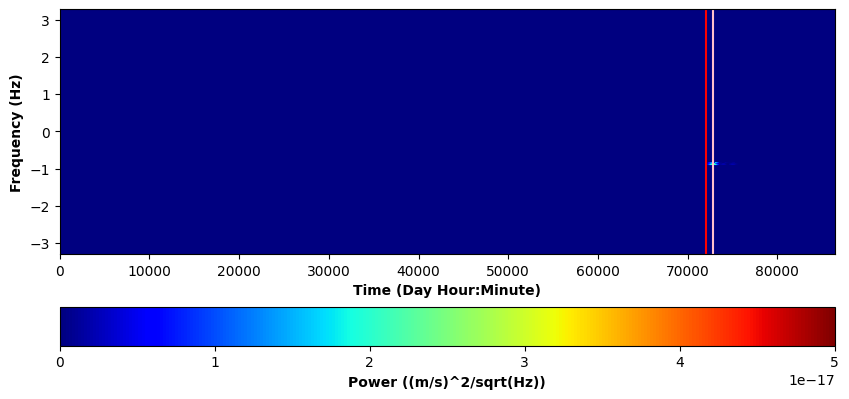

In [19]:
# Plot the time series and spectrogram
fig = plt.figure(figsize=(10, 10))
ax2 = plt.subplot(2, 1, 1)
vals = ax2.pcolormesh(t, f, sxx, cmap=cm.jet, vmax=5e-17)
ax2.set_xlim([min(data_cat['time_rel(sec)']),max(data_cat['time_rel(sec)'])])
ax2.set_xlabel(f'Time (Day Hour:Minute)', fontweight='bold')
ax2.set_ylabel('Frequency (Hz)', fontweight='bold')
ax2.axvline(x=arrival_time_rel, c='red')
ax2.axvline(x=start_time, c='pink')
cbar = plt.colorbar(vals, orientation='horizontal')
cbar.set_label('Power ((m/s)^2/sqrt(Hz))', fontweight='bold')


/opt/conda/lib/python3.11/site-packages/matplotlib/cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/opt/conda/lib/python3.11/site-packages/matplotlib/cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


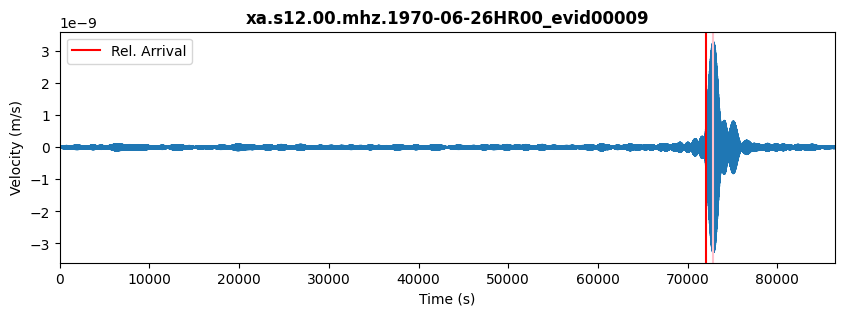

In [20]:
# Read in time steps and velocities
csv_times = np.array(data_cat['time_rel(sec)'].tolist())
csv_data = np.array(data_cat['velocity(m/s)'].tolist())

fig,ax = plt.subplots(1,1,figsize=(10,3))
ax.plot(csv_times,velocity_transformed.tolist())

ax.set_xlim([min(csv_times),max(csv_times)])
ax.set_ylabel('Velocity (m/s)')
ax.set_xlabel('Time (s)')
ax.set_title(f'{test_filename}', fontweight='bold')

arrival_line = ax.axvline(x=arrival_time_rel, c='red', label='Rel. Arrival')
our_arrival_line = ax.axvline(x=start_time, c='pink')
ax.legend(handles=[arrival_line])

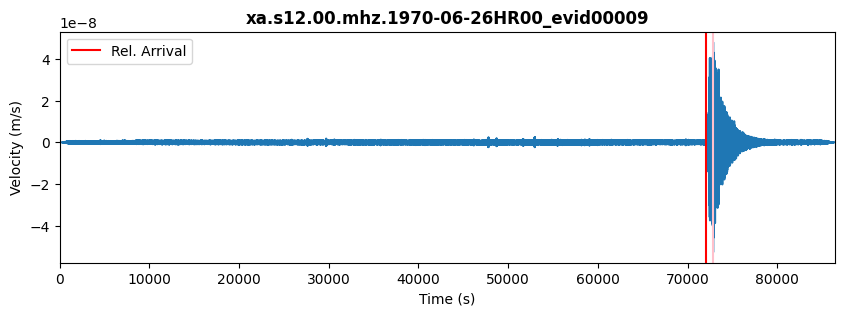

In [21]:
csv_times = np.array(data_cat['time_rel(sec)'].tolist())
csv_data = np.array(data_cat['velocity(m/s)'].tolist())

fig,ax = plt.subplots(1,1,figsize=(10,3))
ax.plot(csv_times,csv_data)

ax.set_xlim([min(csv_times),max(csv_times)])
ax.set_ylabel('Velocity (m/s)')
ax.set_xlabel('Time (s)')
ax.set_title(f'{test_filename}', fontweight='bold')

arrival_line = ax.axvline(x=arrival_time_rel, c='red', label='Rel. Arrival')
ax.legend(handles=[arrival_line])
our_arrival_line = ax.axvline(x=start_time, c='pink')